In this notebook I will focus on visualizing the Covid-19 status in Hong Kong, including the infection situation and vaccination progress. Let's see what interesting insights we can get out of them!


**Data**

The data used in this notebook are from [Our World in Data](https://ourworldindata.org/coronavirus) and the [Hong Kong Government](https://www.covidvaccine.gov.hk/en/dashboard)

In [2]:
## import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.dates import date2num
import seaborn as sns
from pywaffle import Waffle
import calmap
from datetime import datetime as dt
from datetime import timedelta
import random


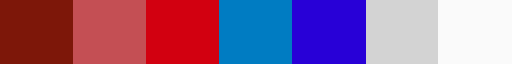

In [3]:
## define the color scheme

dark_hk = '#7d1709'
hk = '#c44f54'
sinovac = '#d20010'
biontech = '#007cc2'
bloomberg = '#2800D7'
others = 'lightgray'
background_color = "#fafafa"
text_color = "#262626"

ListedColormap([dark_hk, hk, sinovac, biontech, bloomberg, others, background_color])

In [4]:
## set default font
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['text.color'] = text_color

In [5]:
## fetch the data from the gov
hk_covid = pd.read_csv('http://www.chp.gov.hk/files/misc/enhanced_sur_covid_19_eng.csv')

## preprocessing 
columns = [column.lower().replace('.','').replace('*','').replace(' ','_') for column in hk_covid.columns]
col_dict = {hk_covid.columns[i]: columns[i] for i in range(len(hk_covid.columns))}
hk_covid.rename(columns= col_dict, inplace=True)
hk_covid.report_date = pd.to_datetime(hk_covid.report_date, format='%d/%m/%Y', errors='coerce').apply(lambda x: x.date())
hk_covid.date_of_onset = pd.to_datetime(hk_covid.date_of_onset, format='%d/%m/%Y', errors='coerce').apply(lambda x: x.date())

In [6]:
## fetch the data from the gov
hk_daily = pd.read_csv('https://static.data.gov.hk/covid-vaccine/bar_vaccination_date.csv')
hk_summary = pd.read_csv('https://static.data.gov.hk/covid-vaccine/summary.csv')
world = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
world_vac = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv')

## stamp the date on which the data is fetched
data_date = dt.today().date()

## preprocessing -- convert to datetime
hk_daily.date = pd.to_datetime(hk_daily.date)
world.date = pd.to_datetime(world.date)
world_vac.date = pd.to_datetime(world_vac.date)

## preprocessing -- convert percentage string to float
hk_summary.firstDosePercent = hk_summary.firstDosePercent.apply(lambda x: float(x.strip('%'))/100)
hk_summary.secondDosePercent = hk_summary.secondDosePercent.apply(lambda x: float(x.strip('%'))/100)

## Confirmed Cases

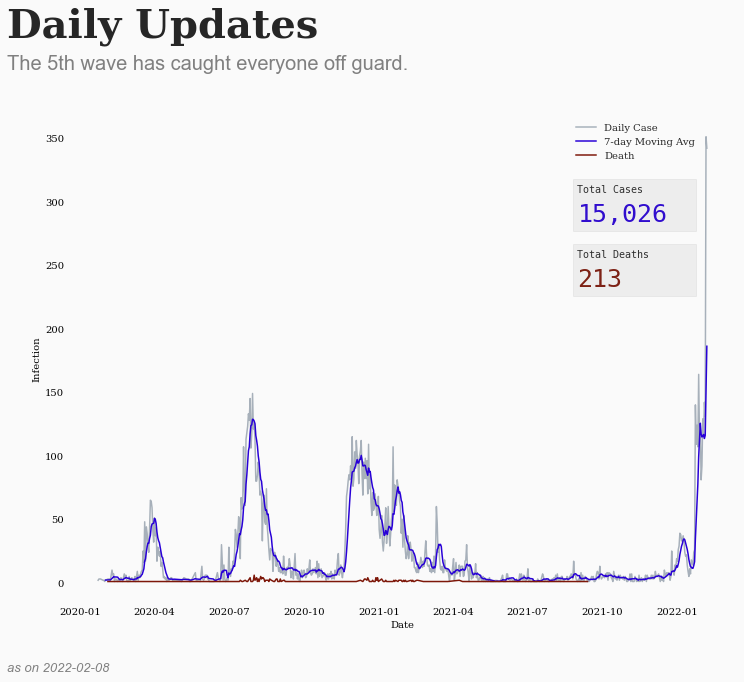

In [14]:
## Daily confirmed cases
daily_case = hk_covid.groupby('report_date', as_index=False).agg({'case_no':'count'}) 
daily_case['7d_ma'] = daily_case.case_no.rolling(window=7).mean()

hk_death = world.loc[world.location=='Hong Kong'].dropna(subset=['new_deaths'])
hk_death = hk_death.loc[hk_death.new_deaths > 0]

## form the figure
fig, ax = plt.subplots(figsize=(12,9), facecolor=background_color)
ax.plot(daily_case.report_date, daily_case.case_no, color='slategrey', alpha=0.6, label='Daily Case')
ax.plot(daily_case.report_date, daily_case['7d_ma'], color=bloomberg, label='7-day Moving Avg')
ax.plot(hk_death.date, hk_death.new_deaths, color=dark_hk, label='Death')
ax.set_xlabel('Date')
ax.set_ylabel('Infection')
ax.legend(facecolor=background_color, framealpha=0, loc='upper right', bbox_to_anchor=(0.95, 1))

## add patches to show the total confirmed cases and deaths
fig.patches.extend([plt.Rectangle((0.71,0.7),0.142,0.08,
                                  fill=True, color='grey', alpha=0.1, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.text(0.715,0.76,'Total Cases',fontfamily='monospace',fontsize=10)
fig.text(0.715,0.715,f"{int(world.loc[world.location=='Hong Kong']['total_cases'].max()):,d}",fontfamily='monospace', 
         color=bloomberg,fontsize=25)


fig.patches.extend([plt.Rectangle((0.71,0.6),0.142,0.08,
                                  fill=True, color='grey', alpha=0.1, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.text(0.715,0.66,'Total Deaths',fontfamily='monospace',fontsize=10)
fig.text(0.715,0.615,f"{int(world.loc[world.location=='Hong Kong']['total_deaths'].max()):,d}",
         fontfamily='monospace', color=dark_hk,fontsize=25)


## title and subtitle and date
fig.text(0.055,1.0,'Daily Updates',fontfamily='serif',fontsize=40,fontweight='bold')
fig.text(0.055,0.95,f'The 5th wave has caught everyone off guard.',color='gray',fontfamily='arial',fontsize=20)
fig.text(0.055,0.02,f'as on {data_date}',color='gray',fontfamily='arial',fontsize=13, style='italic')

# Removing axis and spines
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_visible(False) 

# remove y ticks
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_facecolor(background_color)
# plt.savefig('daily_updates.png', dpi=300, bbox_inches = "tight")
plt.show()


In [8]:
## covid infection per 1000 population
world.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


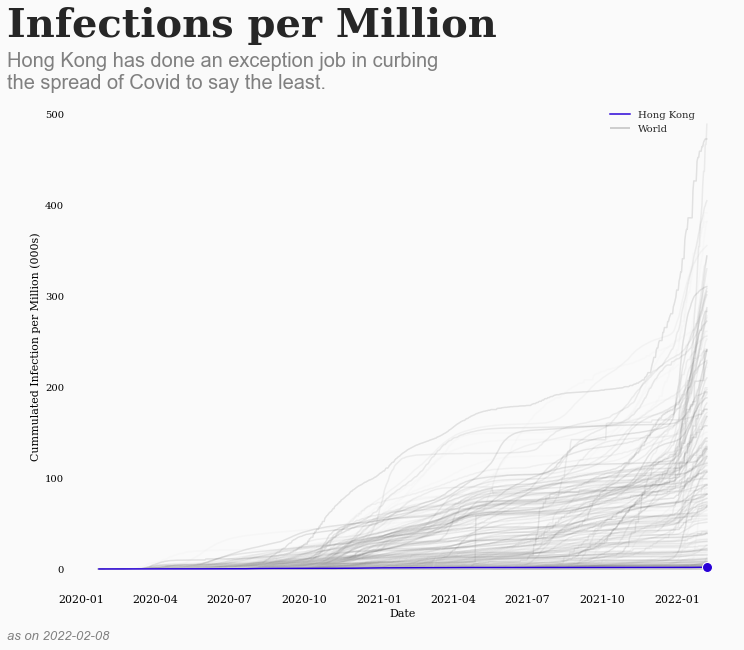

In [9]:
## timeseries of vaccination progress - hk vs regional countries

## form the figure
fig, ax = plt.subplots(figsize=(12,9), facecolor=background_color)
ax = sns.lineplot(data=world, x='date',y=world['total_cases_per_million']/1000,hue='location', palette='Greys_r', alpha=0.1, legend=False)
ax = sns.lineplot(data=world[world.location=='Hong Kong'], x='date',y=world[world.location=='Hong Kong']['total_cases_per_million']/1000, label='Hong Kong', color=bloomberg, legend=False)
dummy_date = world.date[0]
ax.hlines(0, xmin=dummy_date, xmax=dummy_date, label='World',color='silver')
ax.set_xlabel('Date',fontsize=11)
ax.set_ylabel("Cummulated Infection per Million (000s)", fontsize=11)

## plot a point in HK
hk_per_mil = world[world.location=='Hong Kong']['total_cases_per_million'].tolist()[-1]/1000
hk_date = world[world.location=='Hong Kong']['date'].tolist()[-1]
ax.scatter(y=hk_per_mil, x=hk_date, s=100, color=bloomberg, edgecolor='white', linewidths= 1, zorder=20) ## end scatter points
ax.legend(facecolor=background_color, framealpha=0, loc='upper right', bbox_to_anchor=(0.95, 1))

## title and subtitle and date
fig.text(0.055,0.98,"Infections per Million",fontfamily='serif',fontsize=40,fontweight='bold')
fig.text(0.055,0.90,f"Hong Kong has done an exception job in curbing \nthe spread of Covid to say the least.",color='gray',fontfamily='arial',fontsize=20)
fig.text(0.055,0.05,f'as on {data_date}',color='gray',fontfamily='arial',fontsize=13, style='italic')


# Removing axis and spines and set spine color
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_visible(False)
ax.spines['left'].set_color('#3b3b3b')    
ax.spines['bottom'].set_color('#3b3b3b')
    
## remove ticks on x and y axis
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.set_tick_params(labelsize=11)
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
# plt.savefig('covid_per_million.png',dpi=300,bbox_inches='tight')
plt.show()

In [16]:
covid_wave

['Wave 1', 'Wave 2', 'Wave 3', 'Wave 4']

In [17]:
## how long did it take for the government to reduce 80% 

daily_case.report_date = pd.to_datetime(daily_case.report_date)
## define the date range for the 4 waves
wave1 = daily_case.loc[(daily_case['report_date'] > '2020-01-23') & (daily_case['report_date'] <= '2020-5-10')]
wave2 = daily_case.loc[(daily_case['report_date'] > '2020-05-10') & (daily_case['report_date'] <= '2020-10-10')]
wave3 = daily_case.loc[(daily_case['report_date'] > '2020-10-10') & (daily_case['report_date'] <= '2021-3-10')]
wave4 = daily_case.loc[(daily_case['report_date'] > '2021-2-15') & (daily_case['report_date'] <= '2021-7-10')]
waves = [wave1, wave2, wave3, wave4]

covid_wave = []
max_date = []
max_case = []
min_date = []
min_case = []

percent = 0.9   ## declare percentage 

for ix, wave in enumerate(waves):
    wave_max = wave.loc[wave.case_no==wave.case_no.max()]
    for i in range(wave_max.index[0],wave.index[-1]):
        maxx = wave_max.case_no.values[0]
        if wave.case_no[i] <= maxx*(1-percent):
            covid_wave.append(f'Wave {ix+1}')
            max_date.append(wave_max.report_date.tolist()[0])
            min_date.append(wave.loc[i].report_date)
            max_case.append(maxx)
            min_case.append(wave.loc[i].case_no)
            break

## form df with the lists
waves_df = pd.DataFrame({'wave': covid_wave,
            'max_date': max_date,
            'max_case': max_case,
            'min_date': min_date,
            'min_case': min_case})

## calculate the days difference between the max and min
waves_df['days_taken'] = (waves_df.min_date - waves_df.max_date).dt.days

In [18]:
waves_df

,wave,max_date,max_case,min_date,min_case,days_taken
0,Wave 1,2020-03-27,65,2020-04-12,4,16
1,Wave 2,2020-07-30,149,2020-08-24,9,25
2,Wave 3,2020-11-29,115,2021-02-15,9,78
3,Wave 4,2021-03-12,60,2021-03-28,1,16


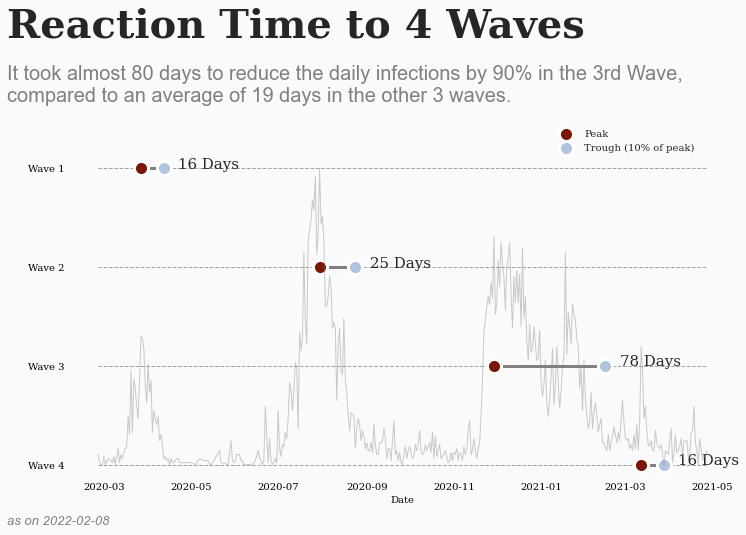

In [19]:
## reverse the order 
waves_df = waves_df.loc[::-1]

## form the figure
fig, ax = plt.subplots(figsize=(12,6), facecolor=background_color)
ax.hlines(y=waves_df.wave, xmin=(waves_df.max_date[0]-timedelta(days=30)), xmax=(waves_df.min_date[3]+timedelta(days=30)), color='gray', alpha=0.7, linewidth=1, linestyles='dashed')
ax.scatter(y=waves_df.wave, x=waves_df.max_date, s=200, color=dark_hk, label='Peak', edgecolor='white',linewidths=3, zorder=10) ## start scatter points
ax.hlines(y=waves_df.wave, xmin=waves_df.max_date, xmax=waves_df.min_date, color='grey', linewidth=3, zorder=1) ## line in between points
ax.scatter(y=waves_df.wave, x=waves_df.min_date, s=200, color='lightsteelblue',label='Trough (10% of peak)', edgecolor='white', linewidths=3, zorder=20,) ## end scatter points
ax.set_xlabel('Date')
ax.legend(facecolor=background_color, framealpha=0, loc='upper right', bbox_to_anchor=(0.95, 1.1))

## annotate
for i in range(len(waves_df)):
    ax.annotate(text=f'{waves_df.days_taken[i]} Days', xy=(waves_df.min_date[i]+timedelta(days=10),waves_df.wave[i]), fontsize=15, zorder=30)

## data for line plot
data_ = daily_case.loc[(daily_case.report_date >= waves_df.max_date[0]-timedelta(days=30)) & (daily_case.report_date <= waves_df.min_date[3]+timedelta(days=30))]
ax2 = ax.twinx()
ax2.plot(data_.report_date, data_.case_no,color='gray', alpha=0.4, linewidth=1)
ax2.set_yticks([]) ## empty y axis

## title and subtitle and date
fig.text(0.055,1.15,'Reaction Time to 4 Waves',fontfamily='serif',fontsize=40,fontweight='bold')
fig.text(0.055,1,f'It took almost 80 days to reduce the daily infections by 90% in the 3rd Wave, \ncompared to an average of 19 days in the other 3 waves.',color='gray',fontfamily='arial',fontsize=20)
fig.text(0.055,0.02,f'as on {data_date}',color='gray',fontfamily='arial',fontsize=13, style='italic')

# Removing axis and spines
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_visible(False) 
    ax2.spines[s].set_visible(False)
    
# remove y ticks
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_facecolor(background_color)
# plt.savefig('waves.png', dpi=300,bbox_inches = "tight")
plt.show()


## Vaccination Program

In [20]:
hk_summary

,firstDoseTotal,firstDosePercent,secondDoseTotal,secondDosePercent,thirdDoseTotal,latestDaily,sevenDayAvg,firstDoseDaily,secondDoseDaily,thirdDoseDaily,totalDosesAdministered,age5to11FirstDose,age5to11FirstDosePercent,age5to11SecondDose,age5to11SecondDosePercent
0,5414052,0.804,4879509,0.725,1060163,72987,35073,22731,21067,29189,11371109,17282,4.2%,103,0.0%


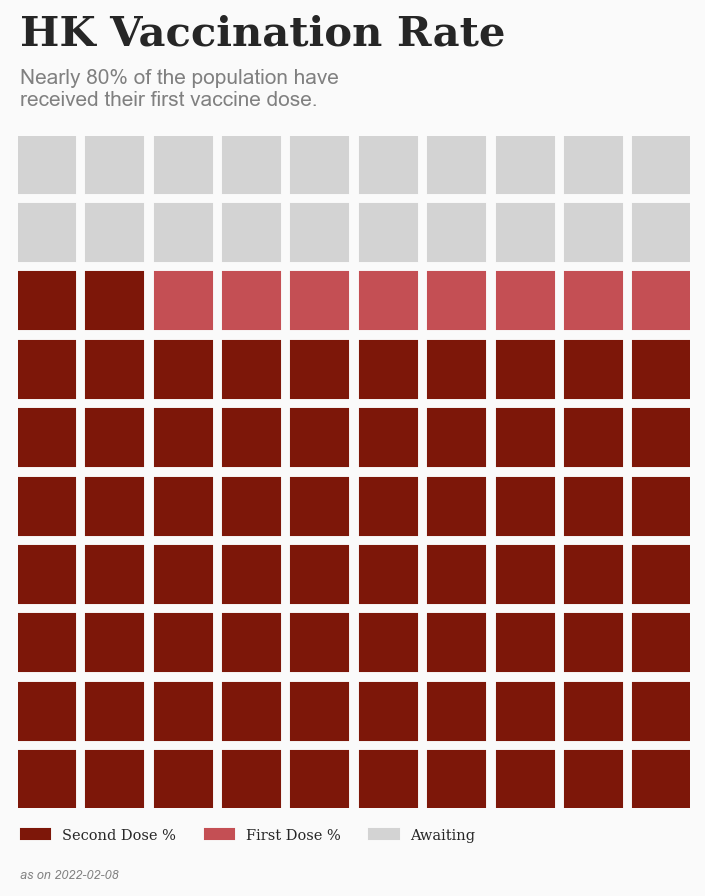

In [21]:
## HK vaccination rate (note: this percentage is based on the population eligible for taking the vaccine instead of the entire population)
second_dose = round(hk_summary.secondDosePercent[0]*100)
first_dose = round(hk_summary.firstDosePercent[0]*100)
awaiting = 100 - first_dose

## form the figure
fig = plt.figure(figsize=(5, 5),dpi=150,facecolor=background_color,
    FigureClass=Waffle,
    rows=10,colors=[dark_hk,hk,others],
    columns=10,vertical=True,
    values={'Second Dose %': second_dose,'First Dose %': first_dose - second_dose, 'Awaiting': awaiting},
    legend={'loc': 'lower left', 'bbox_to_anchor': (-0.015, -0.07), 'ncol': 3, 'framealpha': 0,'fontsize':7})

## title and subtitle and date
fig.text(0.035,1.09,'HK Vaccination Rate',fontfamily='serif',fontsize=20,fontweight='bold')
fig.text(0.035,1.01,f'Nearly {first_dose}% of the population have\nreceived their first vaccine dose.',color='gray',fontfamily='arial',fontsize=10)
fig.text(0.035,-0.02,f'as on {data_date}',color='gray',fontfamily='arial',fontsize=6, style='italic')

fig.set_facecolor(background_color)
# plt.savefig('hk_vac_waffle.png', dpi=300,bbox_inches = "tight")
plt.show()

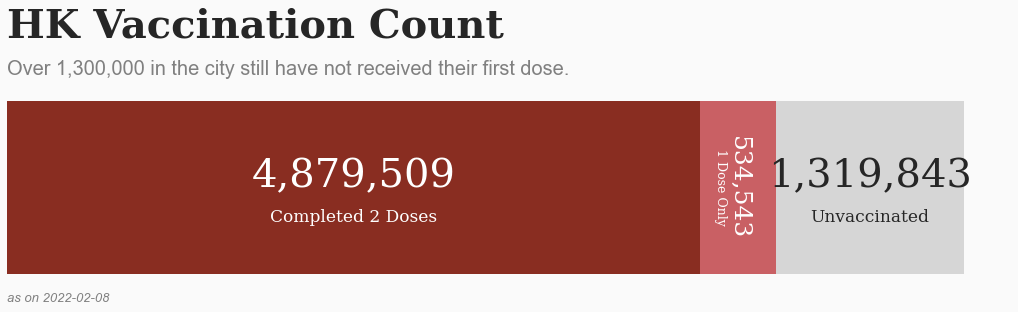

In [22]:
## HK vaccination absolute value

## declare the variables
second_dose = hk_summary.secondDoseTotal[0]
first_dose = hk_summary.firstDoseTotal[0]
first_dose_only = first_dose - second_dose
awaiting = int((hk_summary.firstDoseTotal[0]/hk_summary.firstDosePercent[0]) - first_dose)


## form the figure
fig, ax = plt.subplots(figsize=(18, 3.5))
ax.barh(hk_summary.index, second_dose, 
        color=dark_hk, alpha=0.9, label='Second Dose')
ax.barh(hk_summary.index, first_dose_only, left=second_dose,
        color=hk, alpha=0.9, label='First Dose')
ax.barh(hk_summary.index, awaiting, left=first_dose,
        color='lightgrey', alpha=0.9, label='Awaiting')

## annotate the bar chart - second dose
ax.annotate(f"{second_dose:,d}", 
                   xy=(second_dose/2, 0.05),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
ax.annotate(f"Completed 2 Doses", 
                   xy=(second_dose/2, -0.1),
                   va = 'top', ha='center',fontsize=17, fontweight='light', fontfamily='serif',
                   color='white')

## annotate the bar chart - first dose only
ax.annotate(f"{first_dose_only:,d}", 
                   xy=(second_dose+first_dose_only/2, 0),
                   va = 'center', ha='center',fontsize=25, fontweight='light', fontfamily='serif',
                   color='white', rotation=270)
ax.annotate(f"1 Dose Only", 
                   xy=(second_dose+first_dose_only/2-80000, 0),
                   va = 'center', ha='right',fontsize=12.5, fontweight='light', fontfamily='serif', 
                   color='white',rotation=270)

## annotate the bar chart - unvaccinated
ax.annotate(f"{awaiting:,d}", 
                   xy=(first_dose+awaiting/2, 0.05),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif')
ax.annotate(f"Unvaccinated", 
                   xy=(first_dose+awaiting/2, -0.1),
                   va = 'top', ha='center',fontsize=17, fontweight='light', fontfamily='serif')


## title and subtitle and date
fig.text(0.125,1.1,'HK Vaccination Count',fontfamily='serif',fontsize=40,fontweight='bold')
fig.text(0.125,0.95,f'Over {round(awaiting,-5):,d} in the city still have not received their first dose.',color='gray',fontfamily='arial',fontsize=20)
fig.text(0.125,0.05,f'as on {data_date}',color='gray',fontfamily='arial',fontsize=13, style='italic')


# Removing axis and spines
ax.axis('off')
fig.set_facecolor(background_color)
# plt.savefig('hk_vac_count.png', dpi=300,bbox_inches = "tight")
plt.show()

In [49]:
(hk_daily.date[50] - hk_daily.date[0]).days//7

7

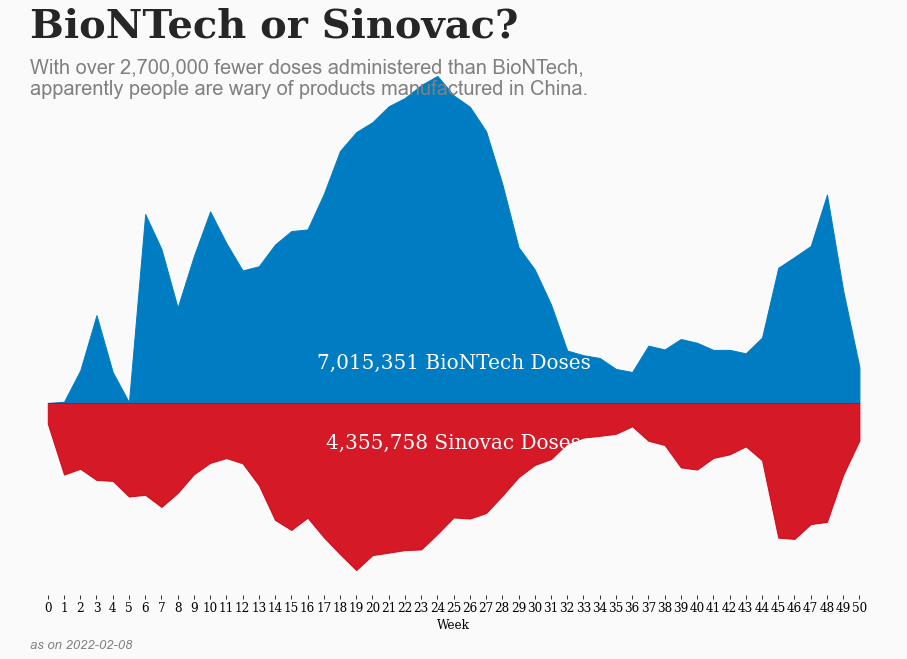

In [51]:
## biontech vs sinovac doses comparison

## week of vaccination programme
hk_daily['week'] = hk_daily.date.apply(lambda x: (x - hk_daily.date[0]).days//7)
weekly_vac = hk_daily.groupby('week').agg({'totalDose.daily.sinovac': 'sum', 'totalDose.daily.biontech': 'sum', 'totalDose.daily.total':'sum'})

## form the figure
fig, ax = plt.subplots(figsize=(16,10))
ax.fill_between(x=weekly_vac.index, y1=weekly_vac['totalDose.daily.biontech'], y2=0, color=[biontech])
ax.fill_between(x=weekly_vac.index, y1=weekly_vac['totalDose.daily.sinovac']*-1, y2=0, color=[sinovac], alpha=0.9)

## annotate the graph
ax.annotate(f"{sum(weekly_vac['totalDose.daily.biontech']):,d} BioNTech Doses", 
                   xy=(weekly_vac.index[-1]/2, 40000),
                   va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='serif',
                   color='white')
ax.annotate(f"{sum(weekly_vac['totalDose.daily.sinovac']):,d} Sinovac Doses", 
                   xy=(weekly_vac.index[-1]/2, -40000),
                   va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='serif',
                   color='white')

## title and subtitle and date
bion_sino = round(sum(weekly_vac['totalDose.daily.biontech']) - sum(weekly_vac['totalDose.daily.sinovac']),-5)
fig.text(0.145,0.9,'BioNTech or Sinovac?',fontfamily='serif',fontsize=40,fontweight='bold')
fig.text(0.145,0.82,f'With over {bion_sino:,d} fewer doses administered than BioNTech, \napparently people are wary of products manufactured in China.',color='gray',fontfamily='arial',fontsize=20)
fig.text(0.145,0.05,f'as on {data_date}',color='gray',fontfamily='arial',fontsize=13, style='italic')

## empty y axis
ax.set_yticks([])

## set x axis labels and font
plt.xticks(weekly_vac.index, fontfamily='serif', fontsize=12)
ax.set_xlabel('Week',fontfamily='serif', fontsize=12)

# Removing axis and spines
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_visible(False)   
    
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
# plt.savefig('bio_sino.png', dpi=300,bbox_inches = "tight")
plt.show()


<Figure size 864x720 with 0 Axes>

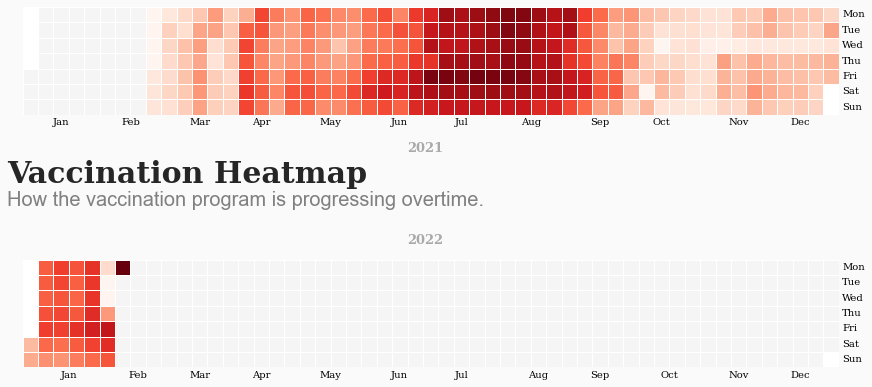

In [40]:
## calendar plot require df.index as datetime
hkdata = hk_daily.set_index('date')

## form the figure
plt.figure(figsize=(12,10), facecolor='grey')
calmap.calendarplot(hkdata['totalDose.daily.total'],fig_kws={'figsize': (12,9), 'facecolor': background_color}, yearlabels=False, fillcolor='whitesmoke', yearlabel_kws={'color':'black', 'fontsize':14})
plt.text(-1,12,'Vaccination Heatmap', fontsize=30, fontweight='bold')
plt.text(-1,10.5,'How the vaccination program is progressing overtime.', fontfamily='arial', fontsize=20, color='gray')
plt.text(25,14,'2021', fontsize=13, fontweight='bold',color='darkgrey')
plt.text(25,8,'2022', fontsize=13, fontweight='bold',color='darkgrey')
# plt.savefig('vac_heatmap.png', dpi=300, bbox_inches = "tight")
plt.show()

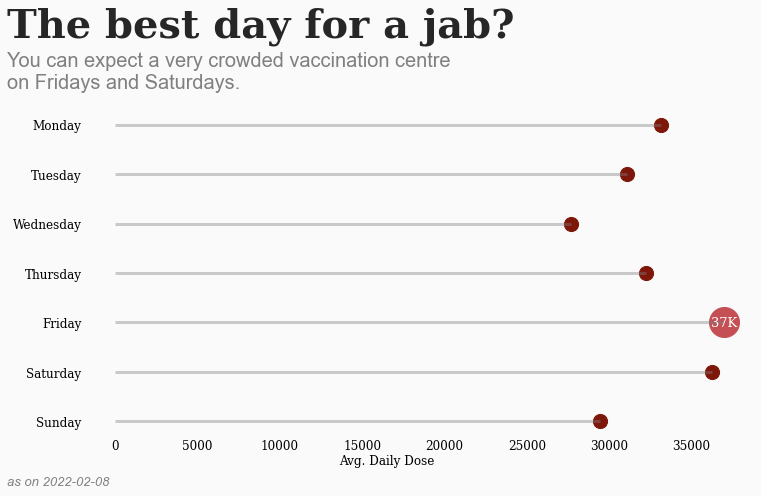

In [41]:
## which weekday more popular for vaccination

## get weekday from a datetime object
hk_daily['weekday'] = hk_daily.date.apply(lambda x: x.strftime("%A"))
weekday_vac = hk_daily.groupby('weekday').agg({'date':'min','totalDose.daily.sinovac': 'mean', 'totalDose.daily.biontech': 'mean', 'totalDose.daily.total':'mean'})
weekday_vac['order'] = [4,0,5,6,3,1,2]
weekday_vac = weekday_vac.reset_index().set_index('order').sort_values('order')
daily_max = weekday_vac[weekday_vac['totalDose.daily.total']==weekday_vac['totalDose.daily.total'].max()]

## form the figure
fig, ax = plt.subplots(figsize=(12,6))
ax.hlines(y=weekday_vac.weekday[::-1], xmin=0, xmax=weekday_vac['totalDose.daily.total'][::-1], color='grey', linewidth=3, alpha=0.4)
ax.scatter(y=weekday_vac.weekday[::-1], x=weekday_vac['totalDose.daily.total'][::-1], s=200, color=dark_hk)
ax.scatter(y=daily_max.weekday, x=daily_max['totalDose.daily.total'], s=900, color=hk)
plt.yticks(fontname = "serif",fontsize=12)
plt.xticks(fontname = "serif",fontsize=12)

## xlabel & adjust position
ax.set_xlabel('Avg. Daily Dose',fontfamily='serif', fontsize=12)
ax.xaxis.set_label_coords(0.45, -0.055)

## highest
ax.annotate(f'{int(round(daily_max["totalDose.daily.total"],-3)/1000)}K', xy=(daily_max['totalDose.daily.total'],daily_max.weekday),
            color='white', fontsize=13, fontfamily='serif', va='center', ha='center', zorder=20)

## title and subtitle and date
fig.text(0.035,1.05,'The best day for a jab?',fontfamily='serif',fontsize=40,fontweight='bold')
fig.text(0.035,0.93,f'You can expect a very crowded vaccination centre \non Fridays and Saturdays.',color='gray',fontfamily='arial',fontsize=20)
fig.text(0.035,0.01,f'as on {data_date}',color='gray',fontfamily='arial',fontsize=13, style='italic')

# Removing axis and spines
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_visible(False)   
    
## remove ticks on x and y axis
ax.tick_params(axis=u'both', which=u'both',length=0)
    
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
# plt.savefig('best_day.png', dpi=300,bbox_inches = "tight")
plt.show()

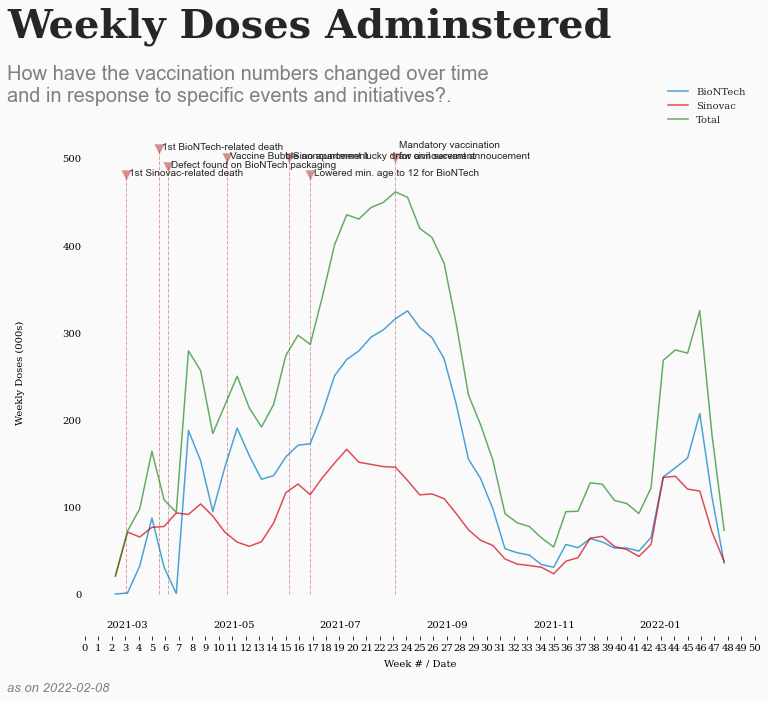

In [52]:
## time series analysis of vaccination in hk

## key events relevant to vaccination - lucky draw, deaths, etc.
key_events = [
(dt(2021,6,2), 'Sino apartment lucky draw annoucement'),
(dt(2021,3,19), '1st BioNTech-related death'),
(dt(2021,2,28), '1st Sinovac-related death'),
(dt(2021,3,24), 'Defect found on BioNTech packaging'),
(dt(2021,4,27), 'Vaccine Bubble announcement'),
(dt(2021,6,14), 'Lowered min. age to 12 for BioNTech'),
(dt(2021,8,2), 'Mandatory vaccination \nfor civil servant annoucement')
]

weekly_vac = hk_daily.groupby('week').agg({'date':'min','totalDose.daily.sinovac': 'sum', 'totalDose.daily.biontech': 'sum', 'totalDose.daily.total':'sum'})


## form the figure
fig, ax = plt.subplots(figsize=(12,9),facecolor=background_color)
ax.plot(weekly_vac.date, weekly_vac['totalDose.daily.biontech']/1000, color=biontech,alpha=0.7, label='BioNTech')
ax.plot(weekly_vac.date, weekly_vac['totalDose.daily.sinovac']/1000, color=sinovac, alpha=0.7, label='Sinovac')
ax.plot(weekly_vac.date, weekly_vac['totalDose.daily.total']/1000, color='forestgreen', alpha=0.7, label='Total')
for event in key_events:
    rand_ = random.randrange(-30,50,10)
    ax.scatter(x=event[0],y=490+rand_, marker='v', s=120,color='firebrick', edgecolors='white', alpha=0.5)
    ax.vlines(x=event[0],ymin=0, ymax=490+rand_, color='firebrick', linestyle='--',linewidth=1, alpha=0.4)
    ax.annotate(text=event[1], xy=(event[0]+timedelta(days=2),490+rand_),fontfamily='arial', fontsize=10)
    
ax.set_ylabel('Weekly Doses (000s)',fontfamily='serif', fontsize=10)
ax.yaxis.set_label_coords(-0.09, 0.5)
ax.legend(facecolor=background_color, framealpha=0, loc='upper right', bbox_to_anchor=(1, 1.1))

## second x axis in terms of week #
ax2 = ax.twiny()
ax2.set_xticks(weekly_vac.index)
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('outward', 20))
ax2.set_xlabel('Week # / Date')
ax2.xaxis.set_label_coords(0.5, -0.1)

## title and subtitle and date
fig.text(0.035,1.02,'Weekly Doses Adminstered',fontfamily='serif',fontsize=40,fontweight='bold')
fig.text(0.035,0.92,f'How have the vaccination numbers changed over time \nand in response to specific events and initiatives?.',color='gray',fontfamily='arial',fontsize=20)
fig.text(0.035,0.01,f'as on {data_date}',color='gray',fontfamily='arial',fontsize=13, style='italic')
    
# Removing axis and spines
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_visible(False) 
    ax2.spines[s].set_visible(False)

# remove y ticks
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_facecolor(background_color)
# plt.savefig('weekly_doses.png', dpi=300,bbox_inches = "tight")
plt.show()


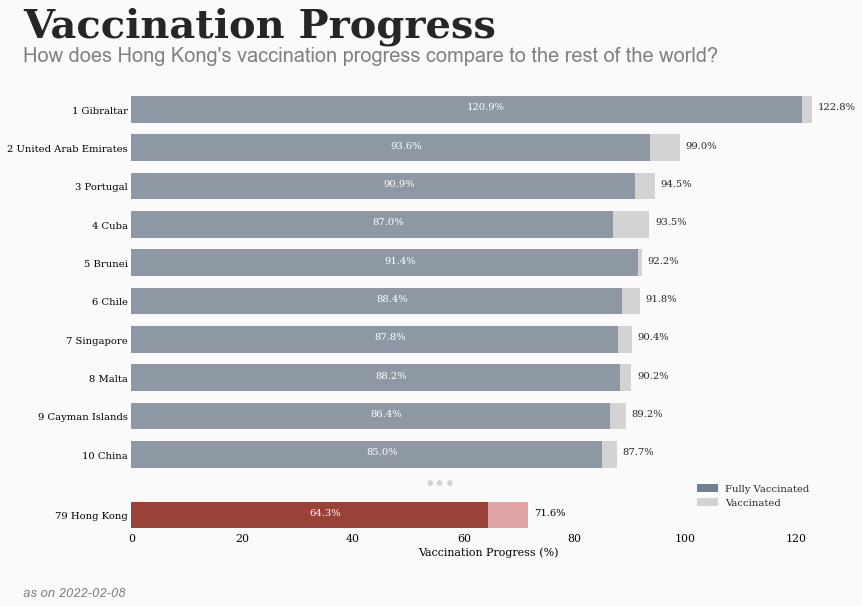

In [53]:
## vaccination rate vs rest of the world
world_latest = world_vac.groupby(['location', 'iso_code'],as_index=False).agg({'date':'max','people_vaccinated':'max','people_fully_vaccinated':'max'})

## join total population
world_latest = world_latest.merge(world.loc[world.date == max(world_vac.date)][['iso_code','population']], left_on='iso_code', right_on='iso_code')

## vaccination rate
world_latest['vaccination_rate'] = (world_latest['people_vaccinated']/world_latest['population'])*100
world_latest['full_vaccination_rate'] = (world_latest['people_fully_vaccinated']/world_latest['population'])*100

## sort the dataframe by vac. rate
world_latest = world_latest.dropna(subset=['vaccination_rate','full_vaccination_rate']).sort_values('vaccination_rate', ascending=True).reset_index(drop=True)
top = 10
world_latest_top = world_latest.tail(top)
world_latest_hk = world_latest.loc[world_latest.location == 'Hong Kong'].reset_index()
hk_position = len(world_latest)+1-world_latest.loc[world_latest.location=='Hong Kong'].index.tolist()[0]


## form the figure
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True, gridspec_kw={'height_ratios': [top, 0.7]})
ax1.barh(y=[f'{x} {y}' for x,y in zip(range(1,len(world_latest_top)+1)[::-1],world_latest_top.location)], width=world_latest_top.vaccination_rate, color='lightgrey', height=0.7)
ax1.barh(y=[f'{x} {y}' for x,y in zip(range(1,len(world_latest_top)+1)[::-1],world_latest_top.location)], width=world_latest_top.full_vaccination_rate, color='slategrey', alpha=0.7, height=0.7)
ax2.barh(y=f'{hk_position} Hong Kong', width=world_latest_hk.vaccination_rate, color=hk, alpha=0.5, height=0.3)
ax2.barh(y=f'{hk_position} Hong Kong', width=world_latest_hk.full_vaccination_rate, color=dark_hk, alpha=0.7, height=0.3)
ax2.set_xlabel("Vaccination Progress (%)", fontsize=11)
fig.tight_layout()

## annotate the values
for x, y in zip([f'{x} {y}' for x,y in zip(range(1,len(world_latest_top)+1)[::-1],world_latest_top.location)],world_latest_top.vaccination_rate):
    ax1.annotate(f'{round(y,1)}%', xy=(y+1, x), fontsize=10)
for x, y in zip([f'{x} {y}' for x,y in zip(range(1,len(world_latest_top)+1)[::-1],world_latest_top.location)],world_latest_top.full_vaccination_rate):
    ax1.annotate(f'{round(y,1)}%', xy=(y/2, x), fontsize=10, color='white')

ax2.annotate(f'{round(world_latest_hk.vaccination_rate[0],1)}%', xy=(world_latest_hk.vaccination_rate[0]+1, f'{hk_position} Hong Kong'), fontsize=10, color='black')
ax2.annotate(f'{round(world_latest_hk.full_vaccination_rate[0],1)}%', xy=(world_latest_hk.full_vaccination_rate[0]/2, f'{hk_position} Hong Kong'), fontsize=10, color='white')

    
## customize legend with mpatches
first_patch = mpatches.Patch(color='slategrey', label='Fully Vaccinated')
second_patch = mpatches.Patch(color='lightgrey', label='Vaccinated')
plt.legend(handles=[first_patch,second_patch],bbox_to_anchor=(0.87,0.45),loc='lower center',ncol=1,
          facecolor=background_color, framealpha=0)

## title and subtitle and date
fig.text(0.035,1.06,"Vaccination Progress",fontfamily='serif',fontsize=40,fontweight='bold')
fig.text(0.035,1.01,f"How does Hong Kong's vaccination progress compare to the rest of the world?",color='gray',fontfamily='arial',fontsize=20)
fig.text(0.035,-0.05,f'as on {data_date}',color='gray',fontfamily='arial',fontsize=13, style='italic')
fig.text(0.5,0.17,f'...',color='lightgrey',fontfamily='serif',fontsize=30, fontweight='bold')


# removing axis and spines
for s in ['top', 'right', 'bottom', 'left']:
    ax1.spines[s].set_visible(False)  
    ax2.spines[s].set_visible(False)  
    
## remove ticks on x and y axis
ax1.tick_params(axis=u'both', which=u'both',length=0)
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.xaxis.set_tick_params(labelsize=11)
fig.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
# plt.savefig('vac_progress_barh.png', dpi=300,bbox_inches = "tight")
plt.show()

In [54]:
## cumulative vaccination rate vs rest of the world over time
world_cum = world_vac[(~world_vac.iso_code.str.contains('OWID'))]

## join total population
world_cum = world_cum.merge(world.loc[world.date == max(world_vac.date)][['iso_code','population']], left_on='iso_code', right_on='iso_code')

## vaccination rate
world_cum['vaccination_rate'] = (world_cum['people_vaccinated']/world_cum['population'])*100
world_cum['full_vaccination_rate'] = (world_cum['people_fully_vaccinated']/world_cum['population'])*100

## drop na
world_cum = world_cum.dropna(subset=['people_vaccinated','population'])

countries = world_cum.groupby('location').agg({'vaccination_rate':'max'}).sort_values('vaccination_rate').tail(15)['vaccination_rate'].index

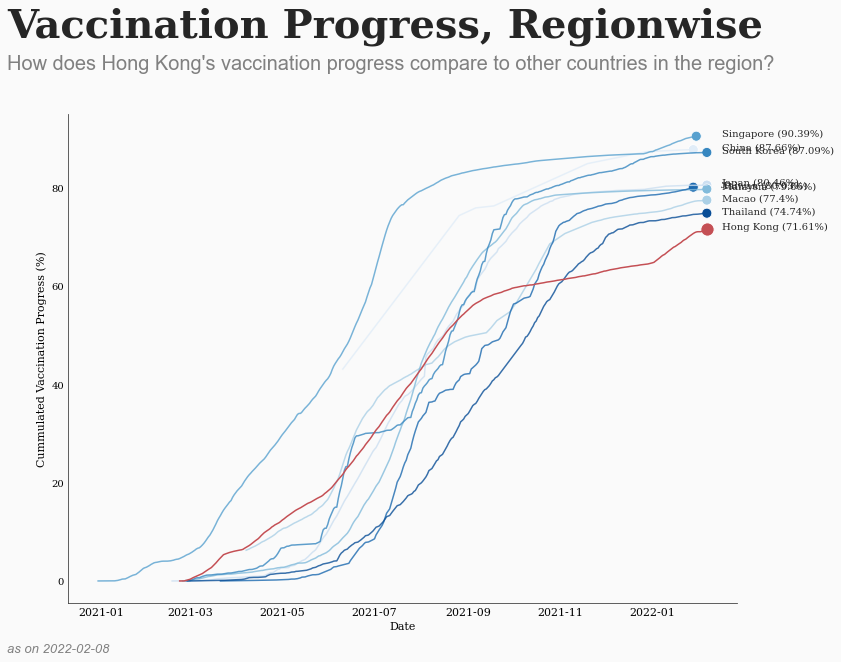

In [56]:
## timeseries of vaccination progress - hk vs regional countries
countries = ['Singapore', 'Taiwan', 'China', 'Japan','Macao', 'Thailand', 'South Korea', 'Malaysia']

## time series analysis of vaccination in hk
fig, ax = plt.subplots(figsize=(12,9), facecolor=background_color)
ax = sns.lineplot(data=world_cum[world_cum.location.isin(countries)], x='date',y='vaccination_rate',hue='location', palette='Blues', alpha=0.8, legend=False)
ax = sns.lineplot(data=world_cum[world_cum.location=='Hong Kong'], x='date',y='vaccination_rate', color=hk, legend=False)
ax.set_xlabel('Date',fontsize=11)
ax.set_ylabel("Cummulated Vaccination Progress (%)", fontsize=11)

## plot the dot at the end of the line
world_ = world_cum[world_cum.location.isin(countries+['Hong Kong'])].groupby('location',as_index=False).agg({'date':'max','vaccination_rate':'max'})
ax = sns.scatterplot(data=world_.loc[world_.location!='Hong Kong'], x='date', y='vaccination_rate', s=100, hue='location', palette='Blues', legend=False)
ax = sns.scatterplot(data=world_.loc[world_.location=='Hong Kong'], x='date', y='vaccination_rate', s=180, color=hk, legend=False)

for i in range(len(world_)):
    ax.annotate(f'{world_.location[i]} ({round(world_.vaccination_rate[i],2)}%)', (max(world_.date)+timedelta(days=10),world_.vaccination_rate[i]))

## title and subtitle and date
fig.text(0.055,1.0,"Vaccination Progress, Regionwise",fontfamily='serif',fontsize=40,fontweight='bold')
fig.text(0.055,0.95,f"How does Hong Kong's vaccination progress compare to other countries in the region?",color='gray',fontfamily='arial',fontsize=20)
fig.text(0.055,0.05,f'as on {data_date}',color='gray',fontfamily='arial',fontsize=13, style='italic')

# removing axis and spines and set spine color
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
ax.spines['left'].set_color('#3b3b3b')    
ax.spines['bottom'].set_color('#3b3b3b')
    
## remove ticks on x and y axis
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.set_tick_params(labelsize=11)
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
# plt.savefig('vac_progress_region.png',dpi=300,bbox_inches='tight')
plt.show()
